In [1]:
%pylab inline
import re
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def loadSORTCERY(file_Dir,uniqueName):
    probabilities = np.array([re.split("\s+",each.strip()) for each in 
                                  open(file_Dir+"norm_distributions_cutoff_100","r").readlines()]).astype(float)
    seqForProbs = open(file_Dir+"sequences_cutoff_100",'r').readlines()
    seqForProbs = [seqForProbs[each].strip().split() for each in range(0,len(seqForProbs))] #Get only the background and seq
    
    #ranking = [each.strip().split() for each in open("/home/vxue/luther/SORTCERY/SORTCERY2_all/ranking_cutoff_100").readlines()]
    #ranking = [int(each[0]) for each in sorted(ranking,key=lambda x: int(x[1]))]
    
    foo = pd.DataFrame({'bg':[str(each[0]) for each in seqForProbs],'seq':[each[1] for each in seqForProbs]})
    foo.loc[foo.bg==str(0),'bg']='P'
    foo.loc[foo.bg==str(1),'bg']='B'
    
    #foo['rank_2_all']=ranking
    for each in range(12):
        foo[uniqueName+'_p'+str(each)]=(probabilities[:,each])
    
    sequencesByRank = foo    
        
    expectedValue = []
    for index,each in sequencesByRank.iterrows():
        probs = each[[uniqueName+'_p'+str(gate) for gate in range(12)]].values
        expectedValue.append(np.dot(probs,np.array(range(12,0,-1))))
    sequencesByRank[uniqueName+'_expectedValue'] = expectedValue
    
    
    copyNum0 = pd.read_csv(file_Dir+'cell_counts_dnaframe_0',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    copyNum1 = pd.read_csv(file_Dir+'cell_counts_dnaframe_1',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    
    #uniqueSeqs0 = pd.read_csv('/home/vxue/luther/SORTCERY/SORTCERY2_Strict_a/unique_seqs_seqframe_0',header=None,delimiter=' ',names=['seq'])
    uniqueSeqs0=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_0','r').readlines()]
    uniqueSeqs1=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_1','r').readlines()]
    
    copyNum0['seq']=uniqueSeqs0
    copyNum1['seq']=uniqueSeqs1
    copyNum0['bg']='P'
    copyNum1['bg']='B'
    combined = copyNum0.append(copyNum1,ignore_index=True)
    combined[uniqueName+'_CN_tot']=combined[[uniqueName+'_CN_'+str(each) for each in range(12)]].sum(axis=1)
    
    
    
    sequencesByRank =  pd.merge(sequencesByRank,combined,on=['seq','bg'])

    return sequencesByRank

In [3]:
uniqueName = ['160906_x100','160902_x1','160826_m1','160819_f100','160831_m1r']
uniqueShortName = ['x100','x1','m1','f100','m1r']

In [4]:
allDF = []
for each,each1 in zip(uniqueName,uniqueShortName):
    foo = loadSORTCERY("/scratch/users/vxue/data/SORTCERY_PUBLICATION/2016_11_09/workspace/"+each+"_dna/",each1)
    allDF.append(foo)

In [5]:
for each in allDF:
    print(len(each))

6489
5869
6412
5788
6139


In [6]:
totalReads = []
for uniqueName,each in zip(uniqueShortName,allDF):
    print(each[uniqueName+'_CN_tot'].sum())
    totalReads.append(each[uniqueName+'_CN_tot'].sum())

20574528
11207601
19814469
13739834
18451008


In [7]:
sum(totalReads)

83787440

In [8]:
sort_m1 = allDF[2]
sort_m1r = allDF[4]

In [9]:
sortm1Merged = pd.merge(sort_m1,sort_m1r, on='seq')

In [10]:
len(sortm1Merged)

5697

In [11]:
import scipy.stats

In [12]:
scipy.stats.pearsonr(sortm1Merged['m1_expectedValue'],sortm1Merged['m1r_expectedValue'])


(0.95070877640279394, 0.0)

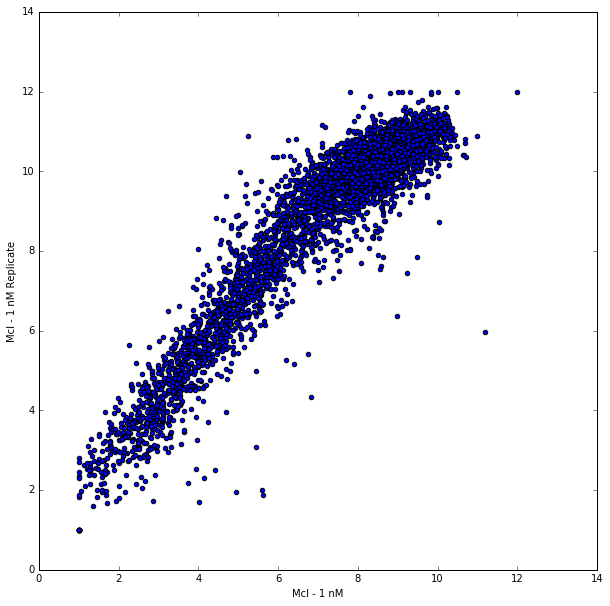

In [13]:
fig,ax = plt.subplots(figsize=(10,10))
scatter(sortm1Merged['m1_expectedValue'],sortm1Merged['m1r_expectedValue'])
xlabel("Mcl - 1 nM")
ylabel("Mcl - 1 nM Replicate")



scatter(sort_m1[sort_m1.seq.str.contains("GRPEIWIAQELRRIGDEFNAYY")][['m1_expectedValue']],
        sort_m1r[sort_m1r.seq.str.contains("GRPEIWIAQELRRIGDEFNAYY")][['m1r_expectedValue']],s=100,color='red')

scatter(sort_m1[sort_m1.seq.str.contains("EQWAREIGAQLRRMADDLNAQY")][['m1_expectedValue']],
        sort_m1r[sort_m1r.seq.str.contains("EQWAREIGAQLRRMADDLNAQY")][['m1r_expectedValue']],s=100,color='blue')

In [14]:
for mySet,prefix in zip(allDF,uniqueShortName):
    mySet.sort_values(by=prefix+'_CN_tot',inplace=True,ascending=False)

In [15]:
myColors = ['red','orange','blue','green','purple']

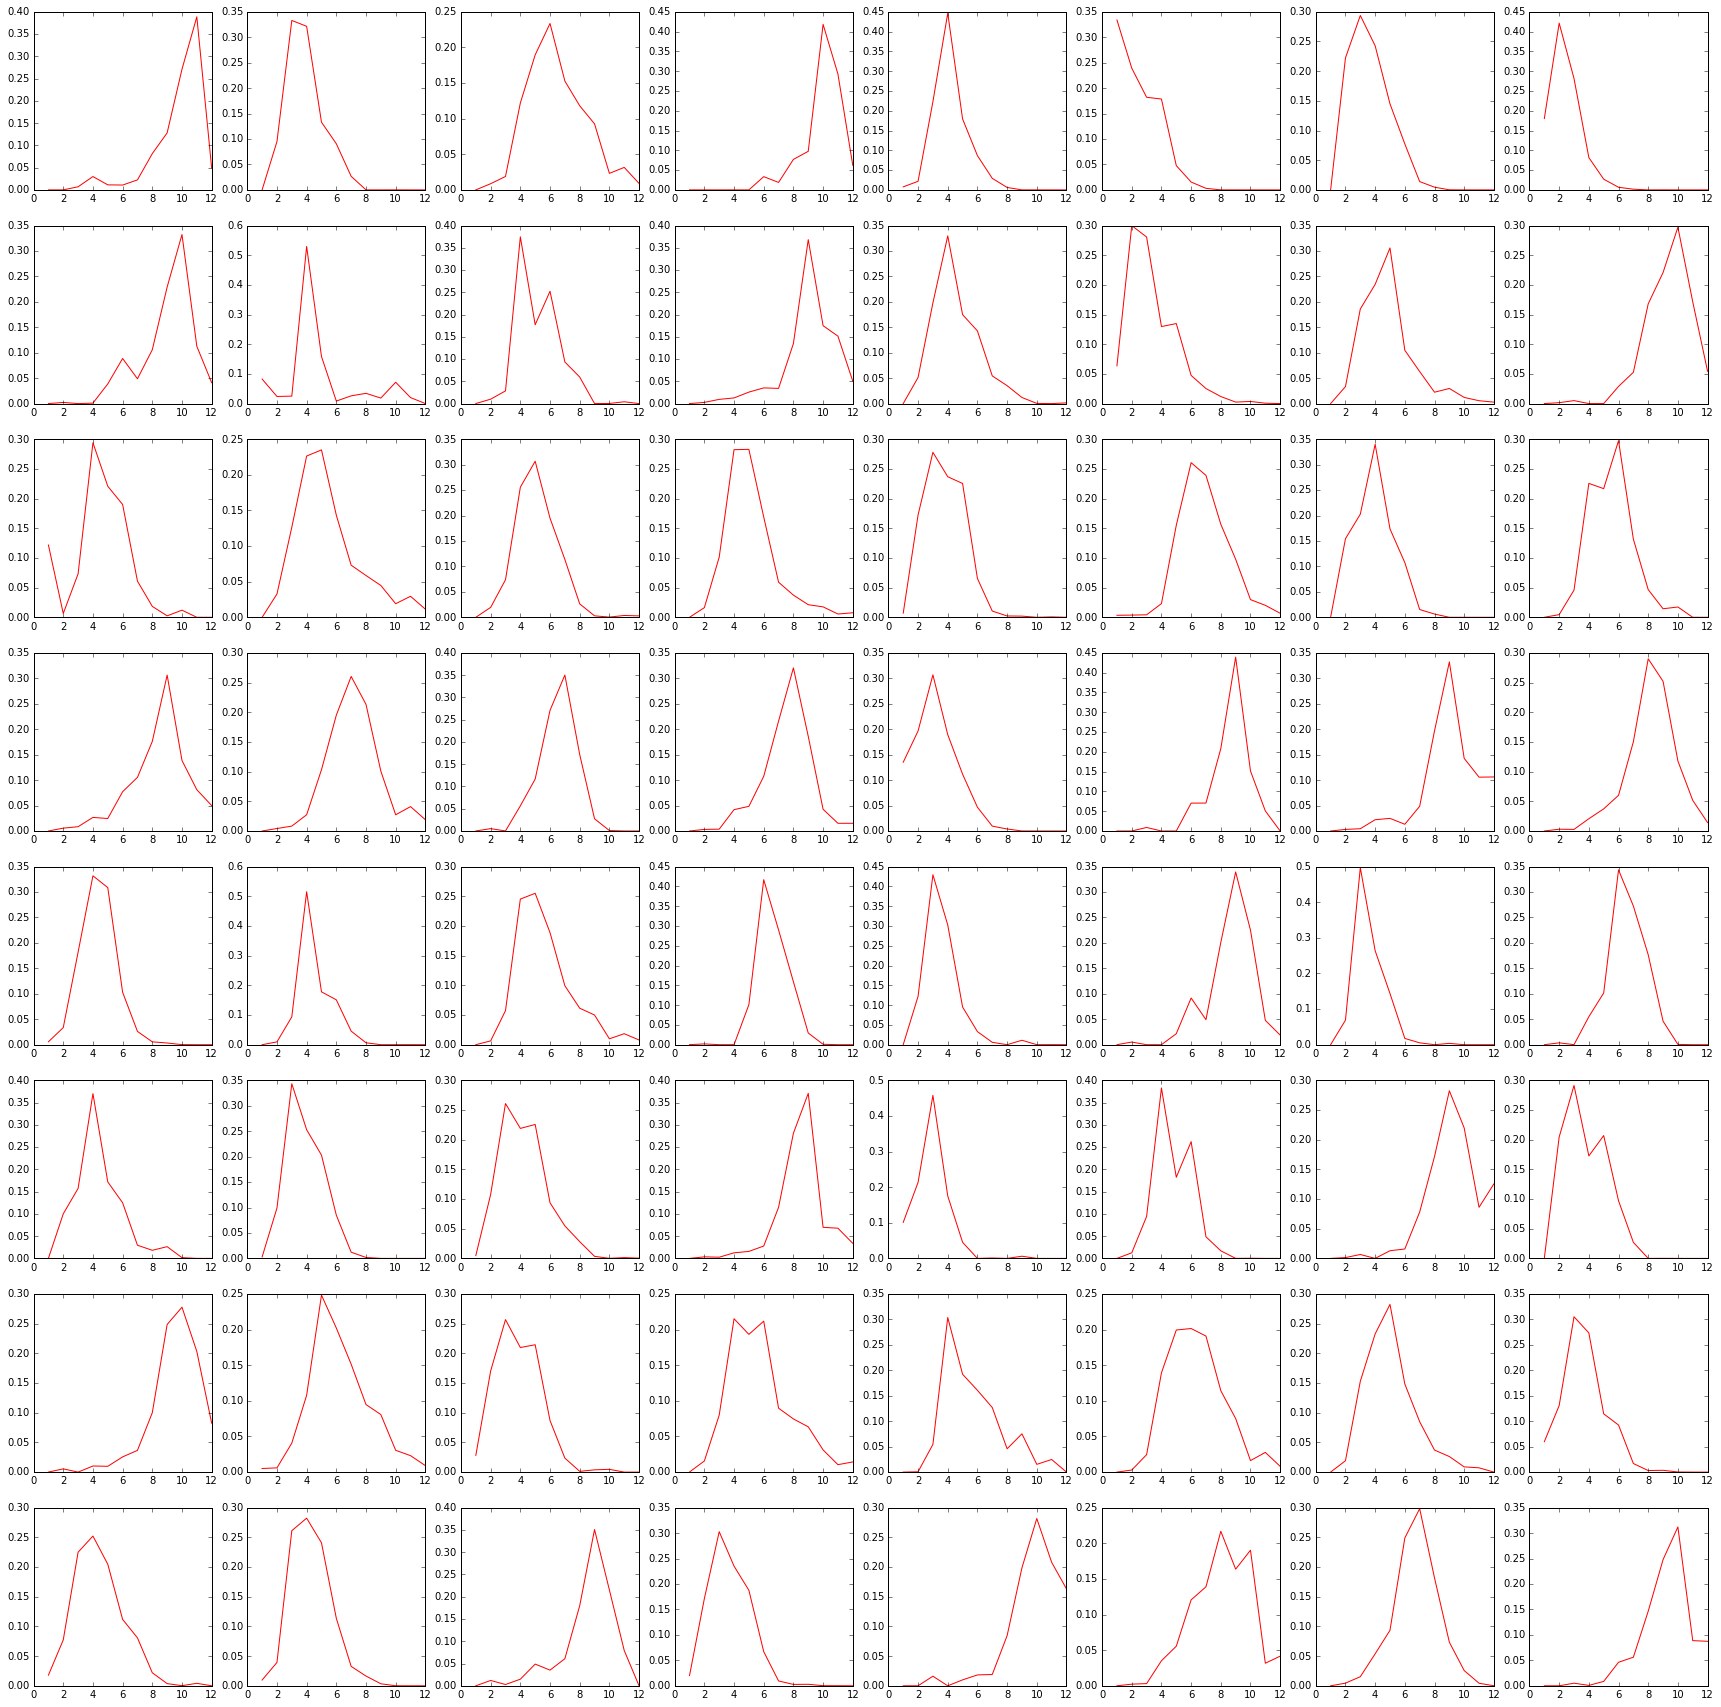

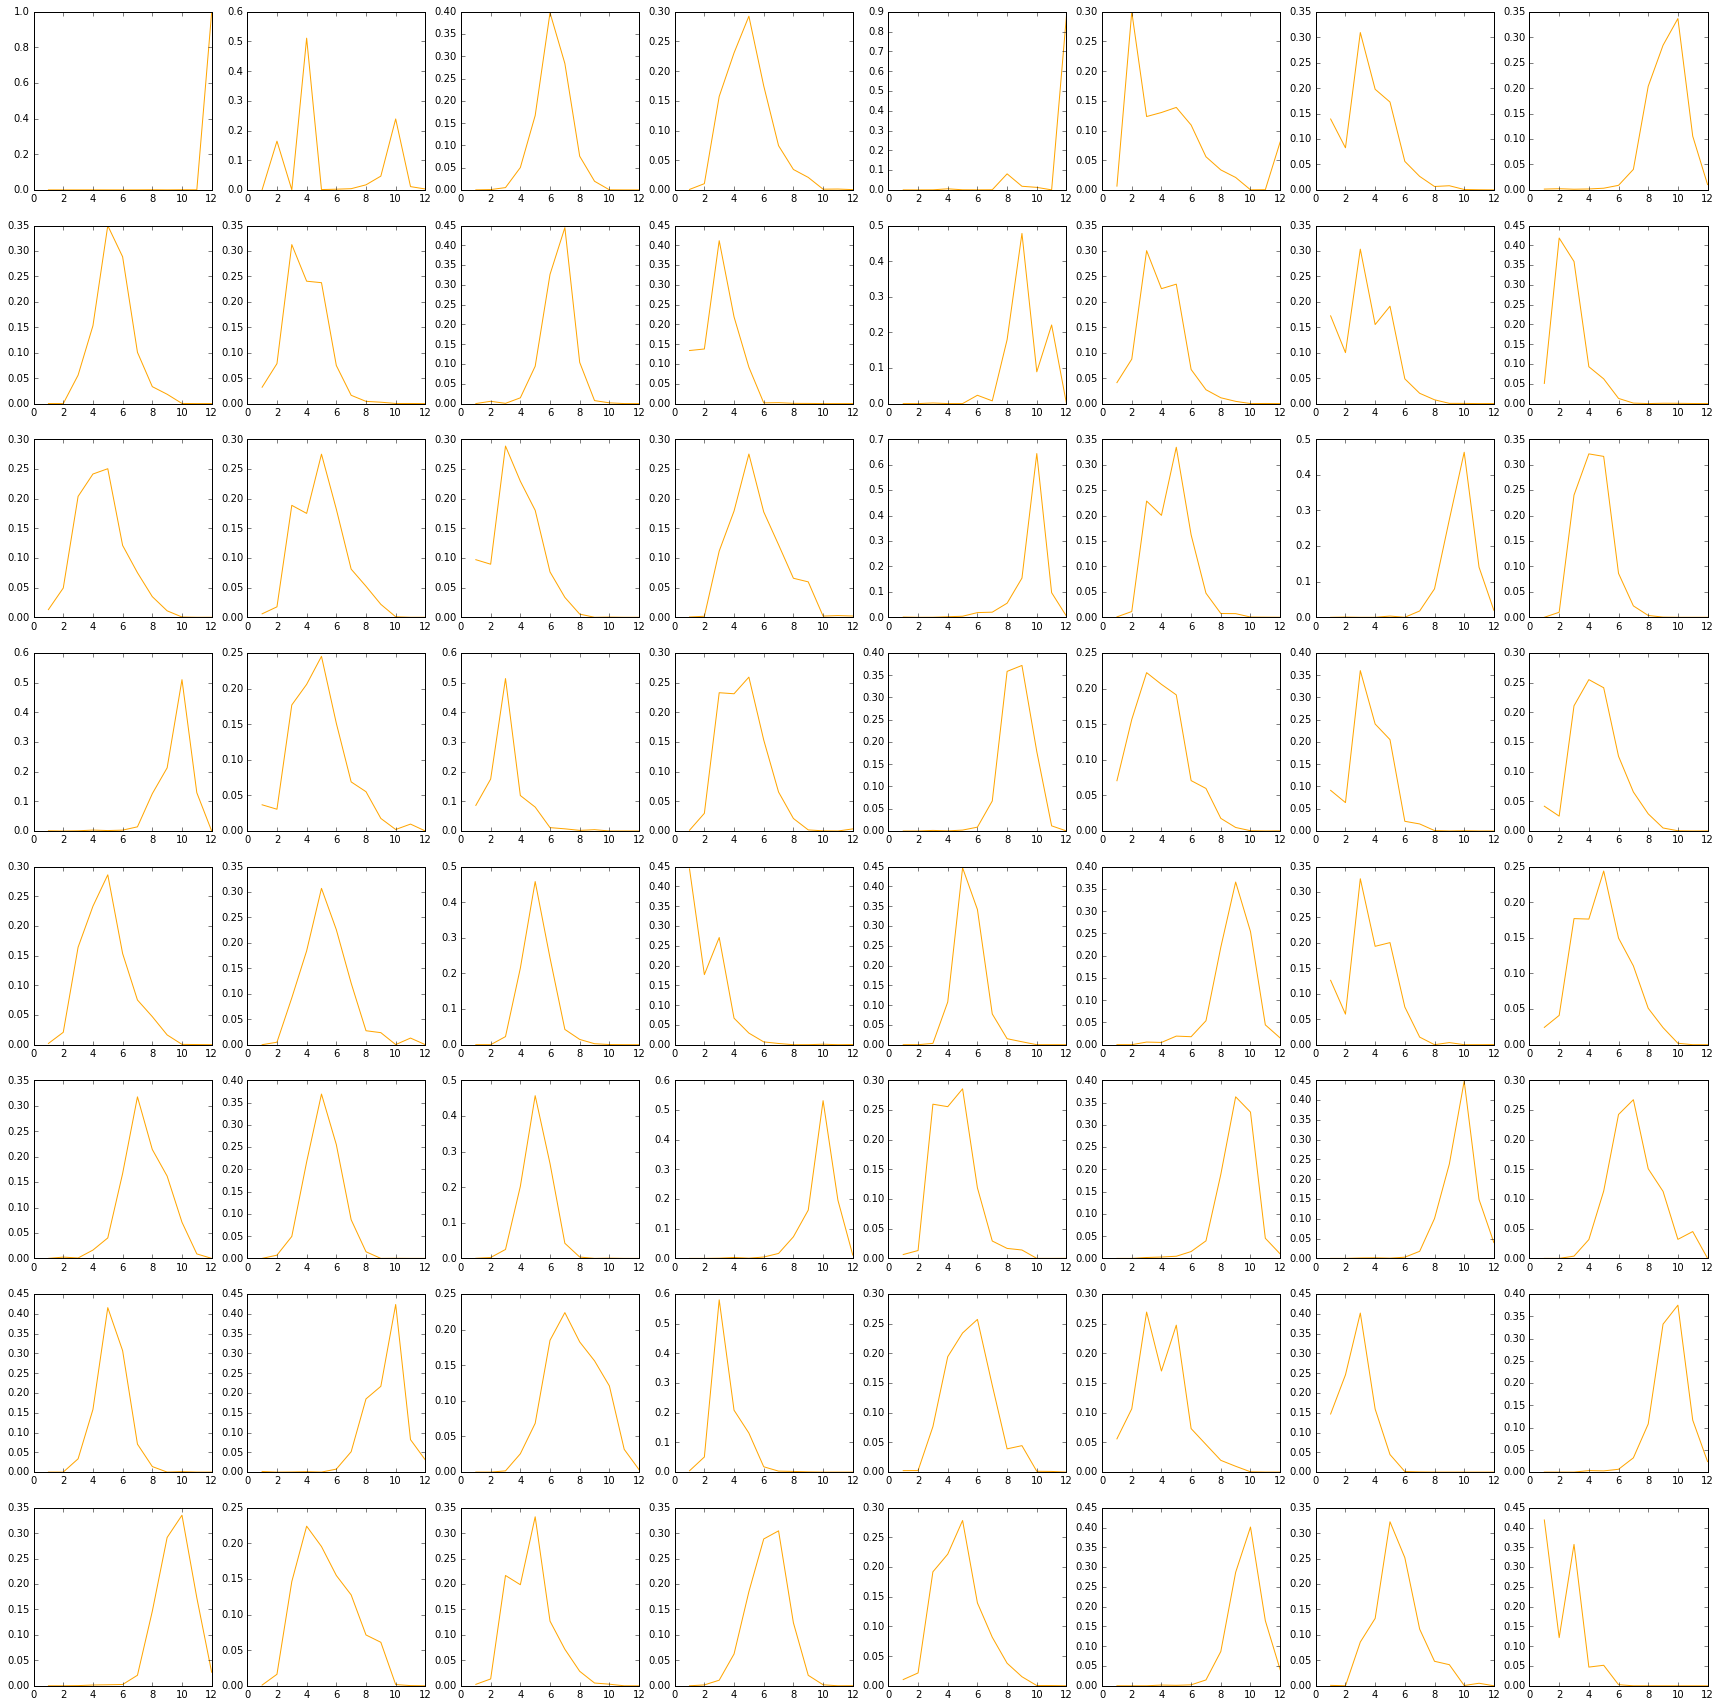

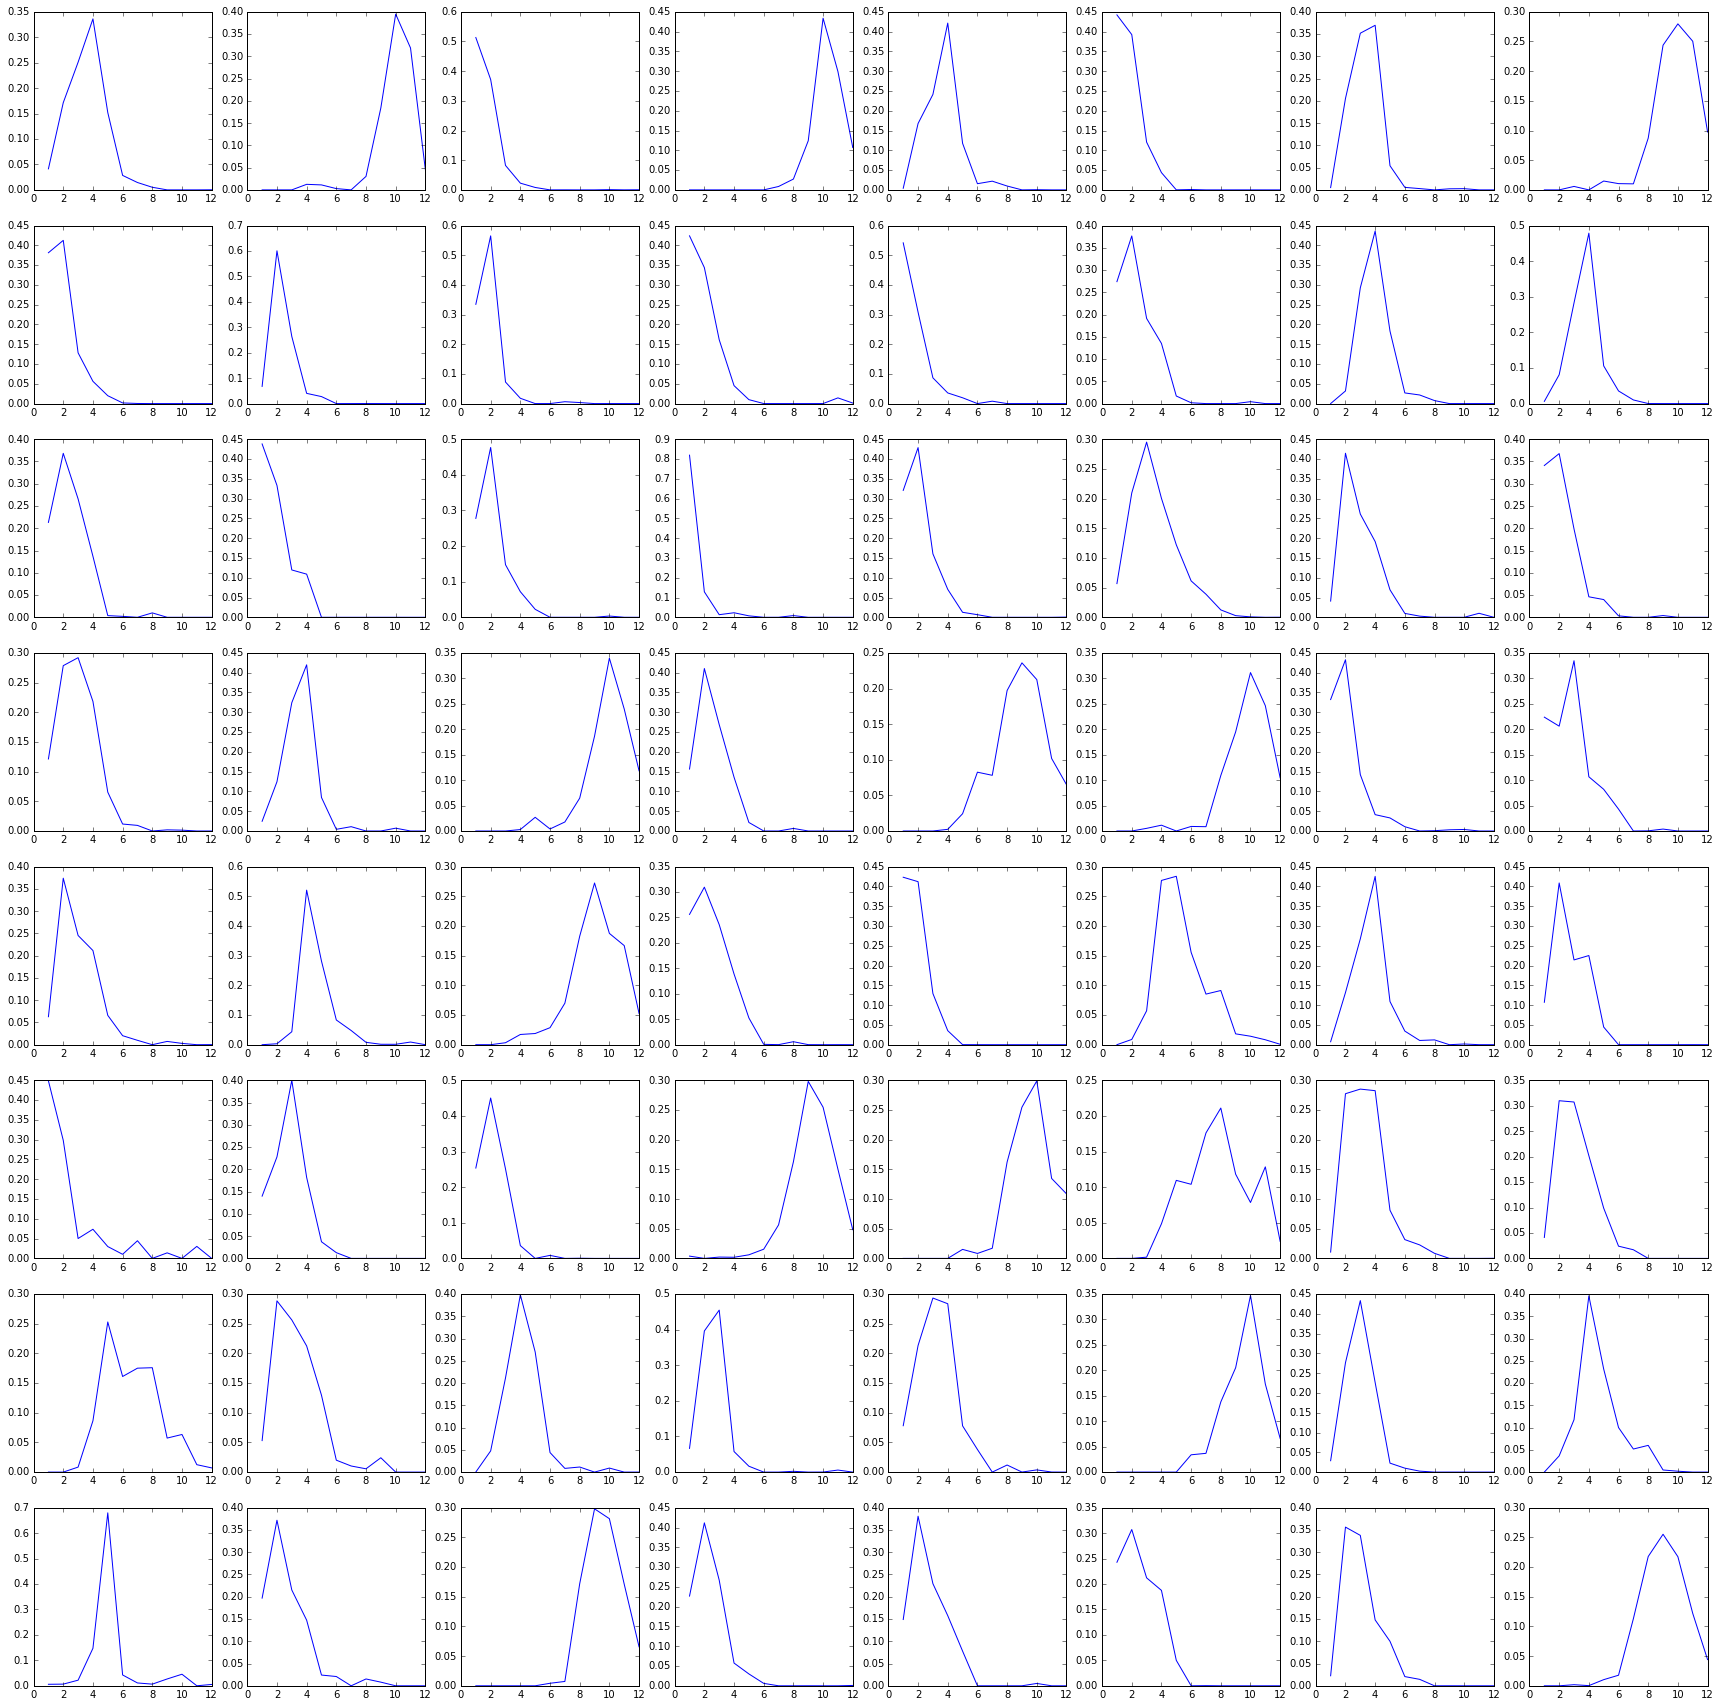

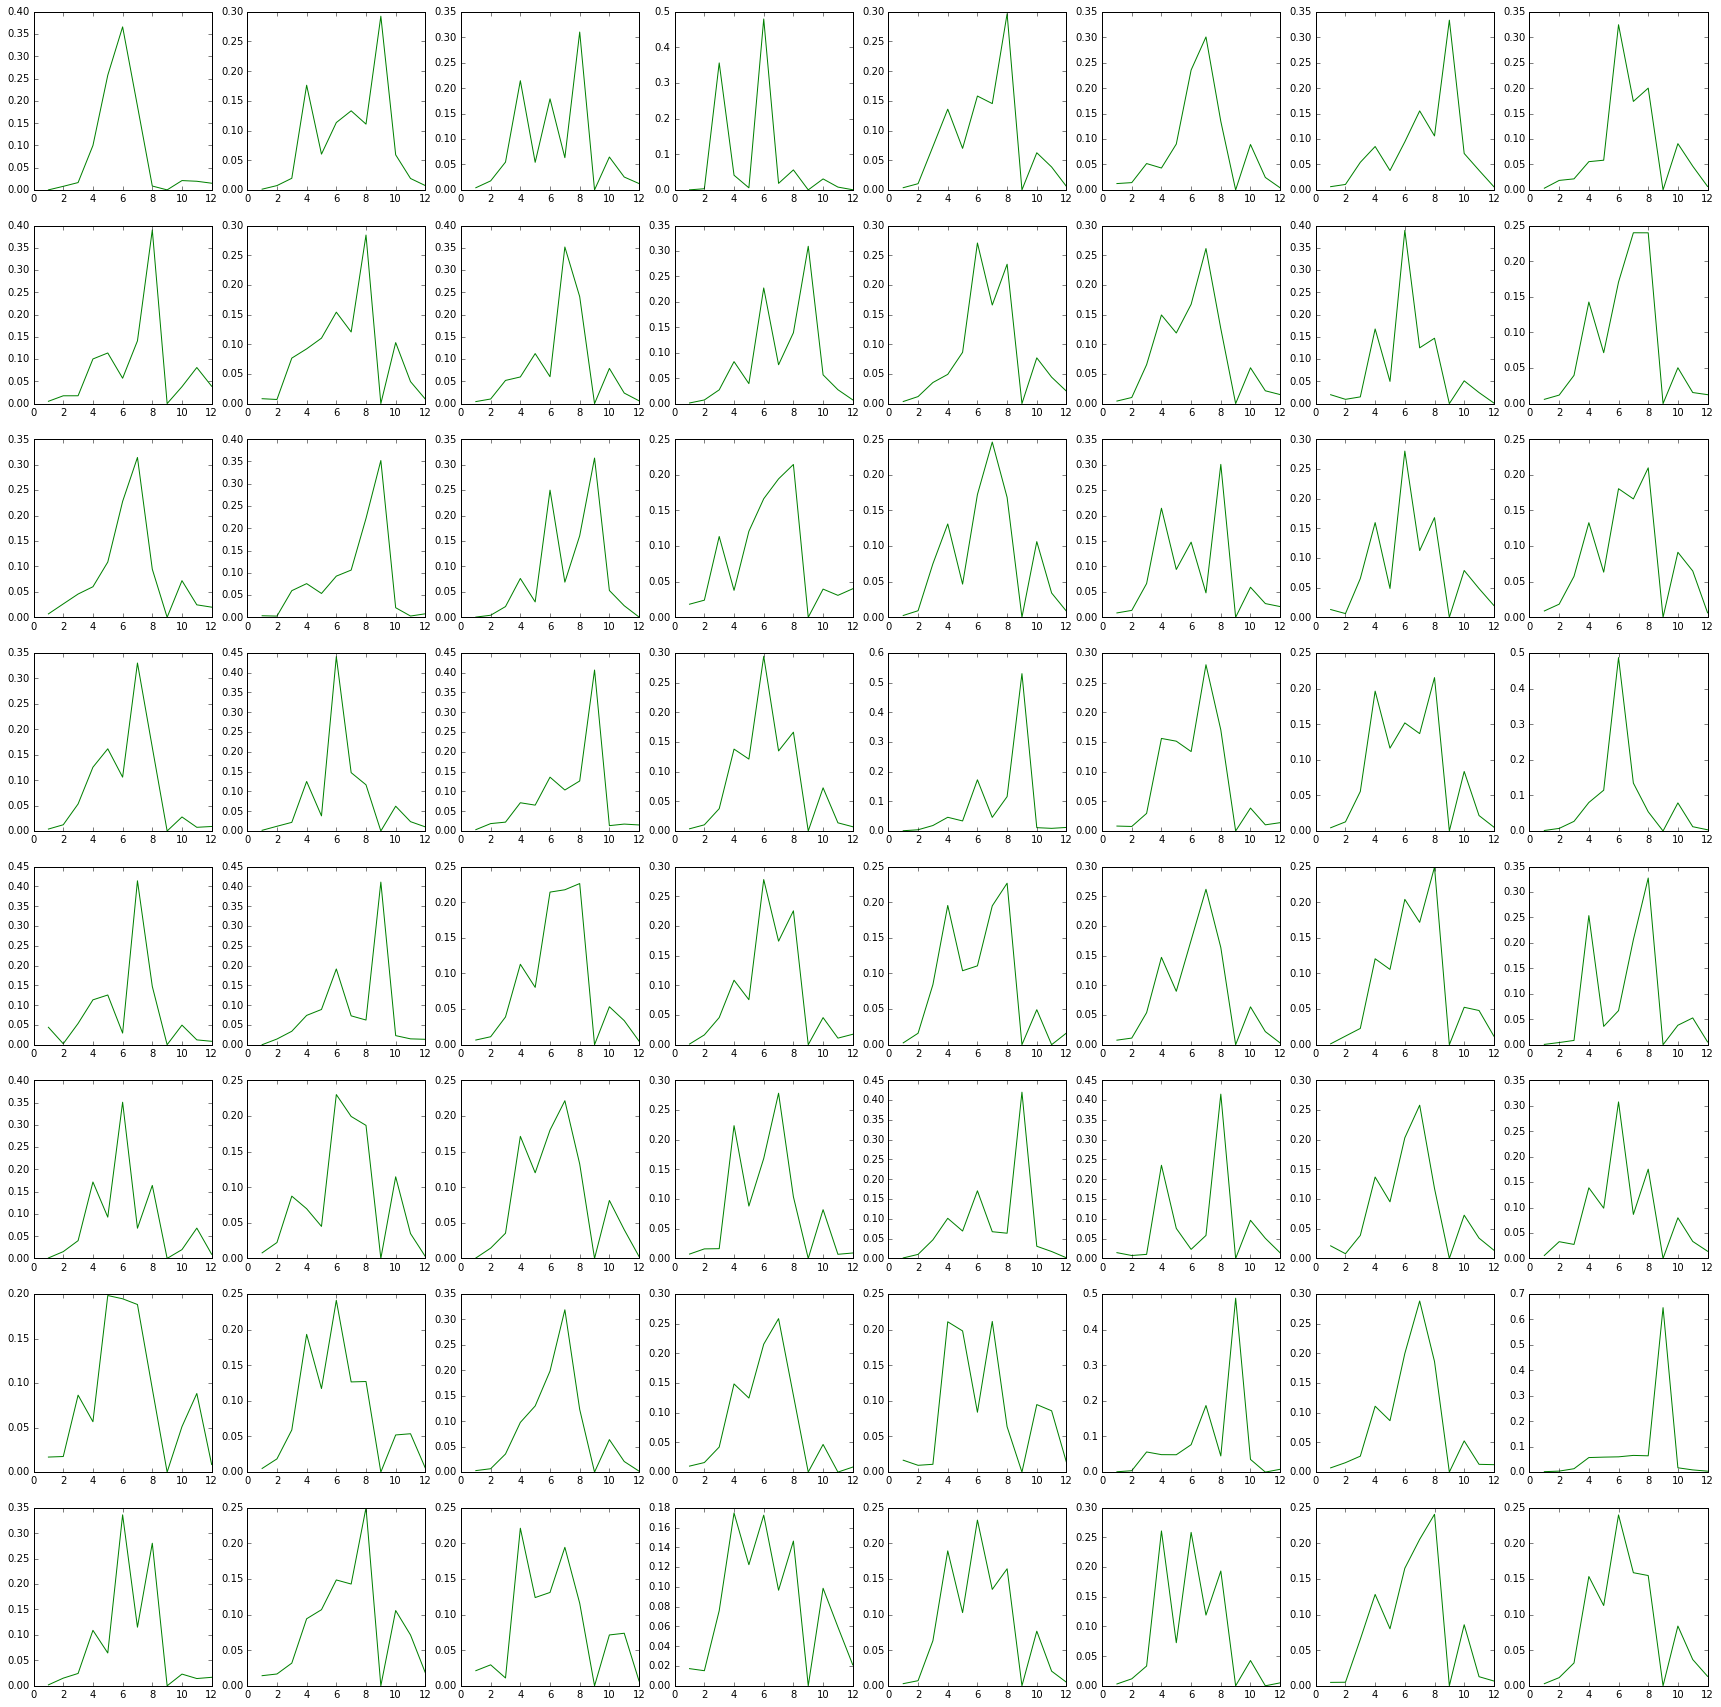

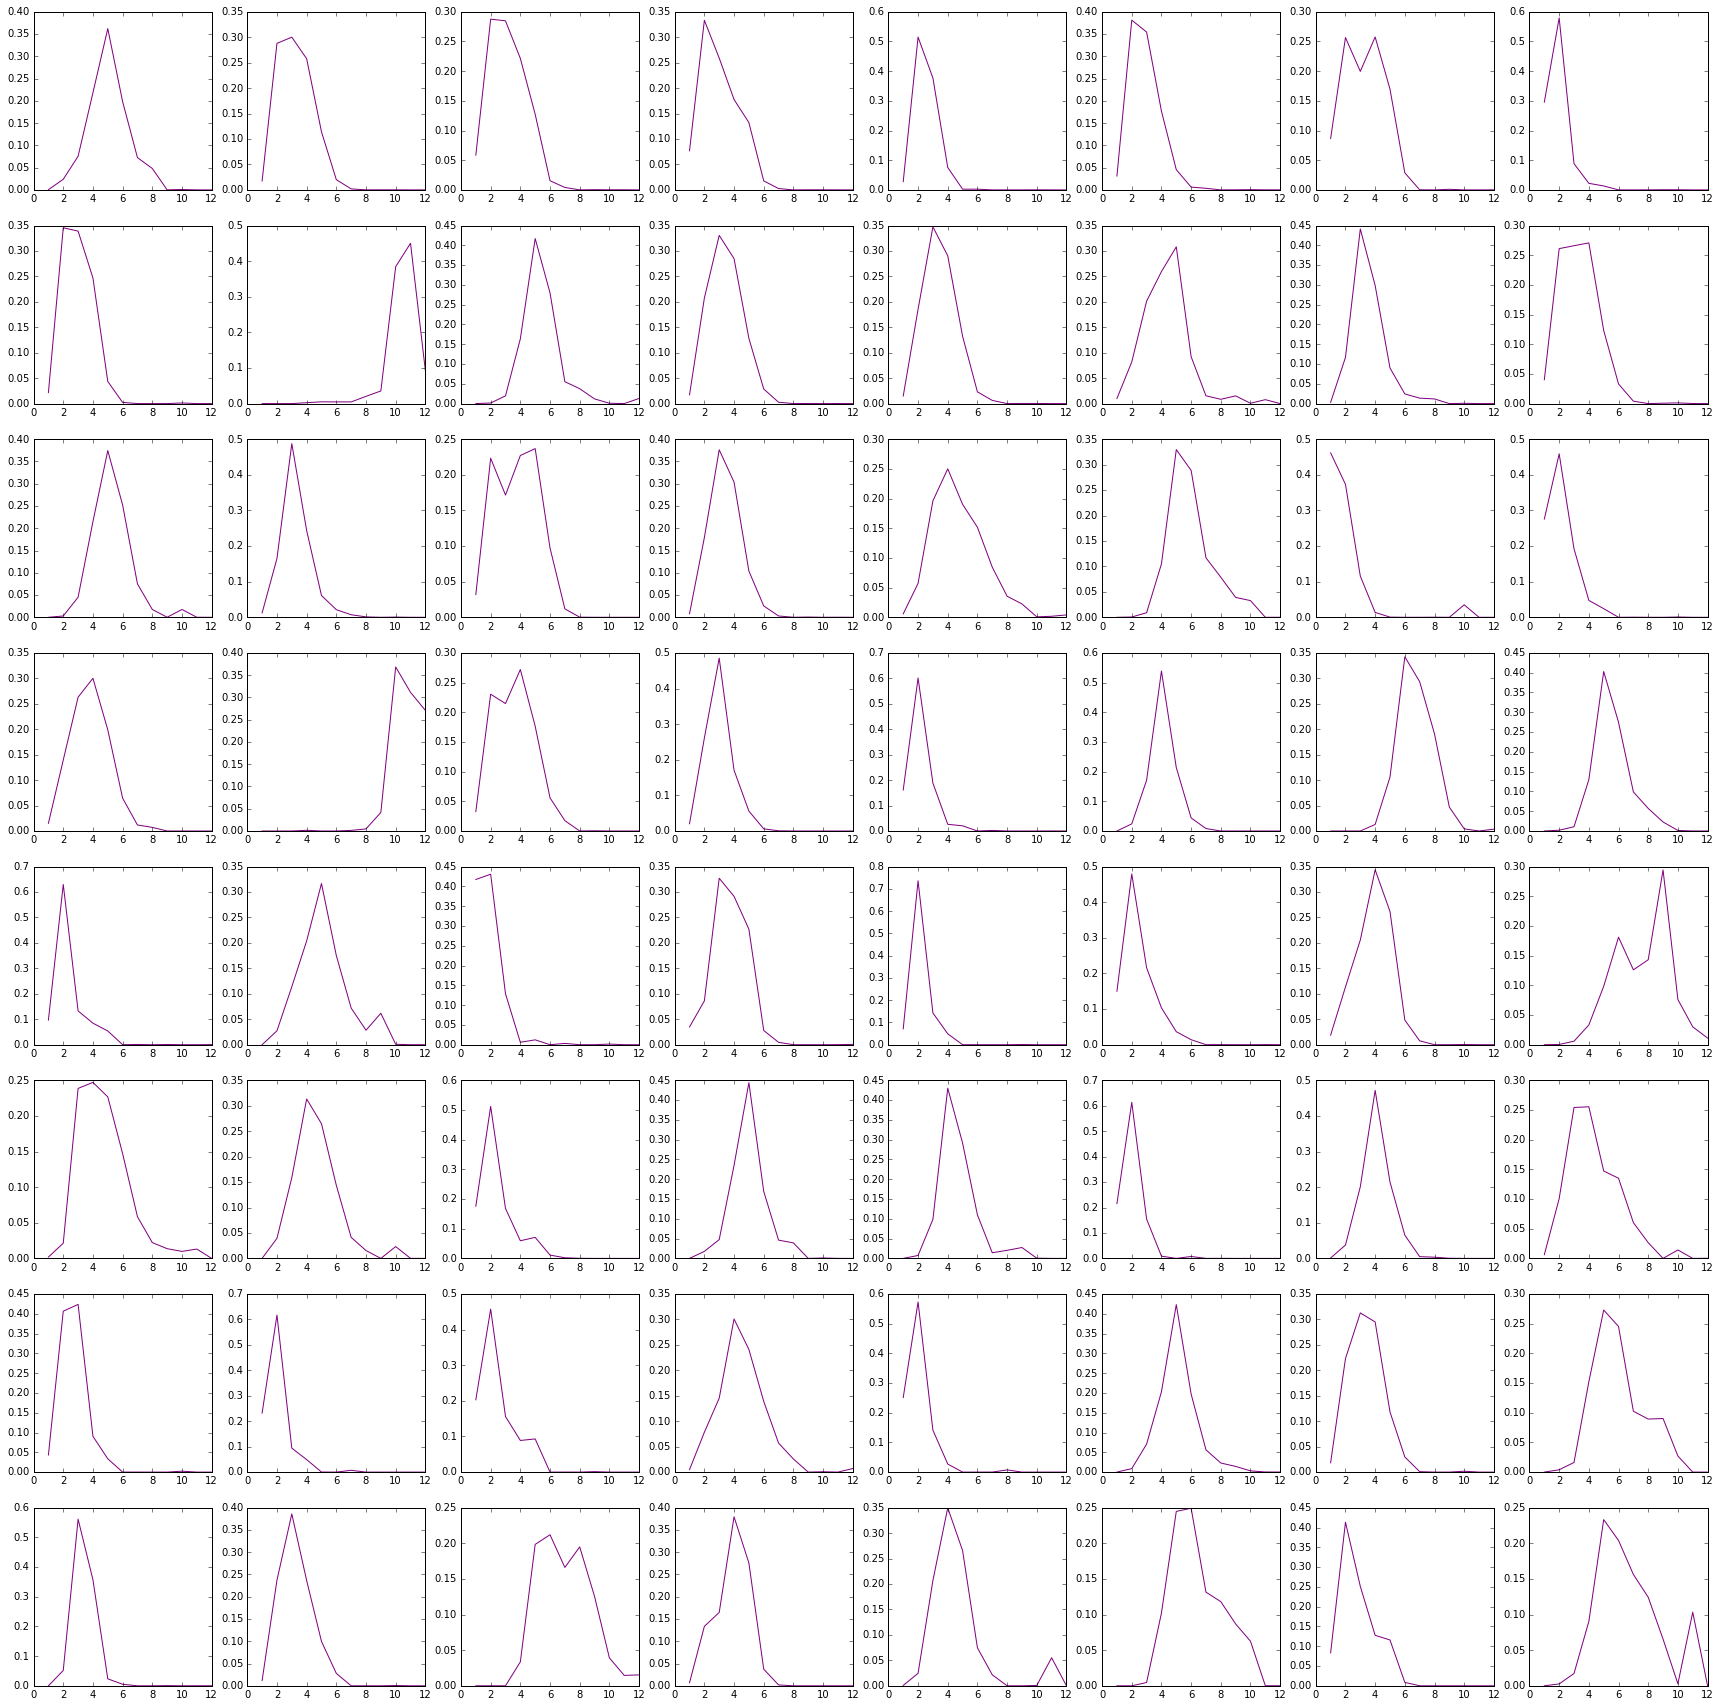

In [16]:
for mySet,prefix in zip(allDF,uniqueShortName):
    fig,ax = plt.subplots(8,8,figsize=(30,30))
    for i in range(64):
        row = i//8
        col = i%8 
        foo = mySet.iloc[i][[prefix+"_p"+str(j) for j in range(12)]].squeeze()
        ax[row][col].plot(range(12,0,-1), foo,color=myColors[uniqueShortName.index(prefix)])


In [17]:
sort_x1 = allDF[1]
sort_x100 = allDF[0]

In [18]:
sortbMerged = pd.merge(sort_x1,sort_x100, on='seq')

In [19]:
len(sortbMerged)

5446

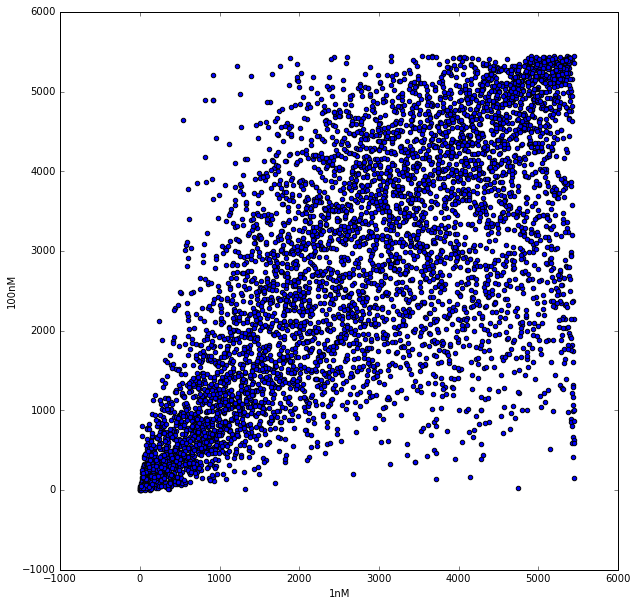

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
scatter(sortbMerged['x1_expectedValue'].rank(),sortbMerged['x100_expectedValue'].rank())

xlabel("1nM")
ylabel("100nM")

In [21]:
import pickle

In [22]:
pickle.dump(allDF,open("/home/vxue/data/SORTCERY_PUBLICATION/2016_11_09/workspace/processed/allData.pickle",'wb'))

In [23]:
# %load PyScripts/makeLogoFromList.py
#SVM_Ranking_29
from weblogolib import *
from IPython.display import Image


def makeLogoFromList(sequences):
    myFile = open("/tmp/seqlogo",'w')
    count = 0
    for each in sequences:
        if("*" not in each and "X" not in each):
            myFile.write(each+"\n")
            #myFile.write("\n")
        count+=1
        #if (count>10000):
        #    break|
    myFile.close()
    
    myFile=open("/tmp/seqlogo",'r')
    seqs = read_seq_data(myFile)
    data = LogoData.from_seqs(seqs)
    options = LogoOptions()
    options.fineprint=""
    options.resolution=300
    options.fontsize=8
    options.unit_name="probability"
    myFormat = LogoFormat(data, options)
    return png_formatter(data,myFormat)

temp = makeLogoFromList(['AATCGA'])
myFile=open("/tmp/seqlogo",'r')
seqs = read_seq_data(myFile)   
data = LogoData.from_seqs(seqs)


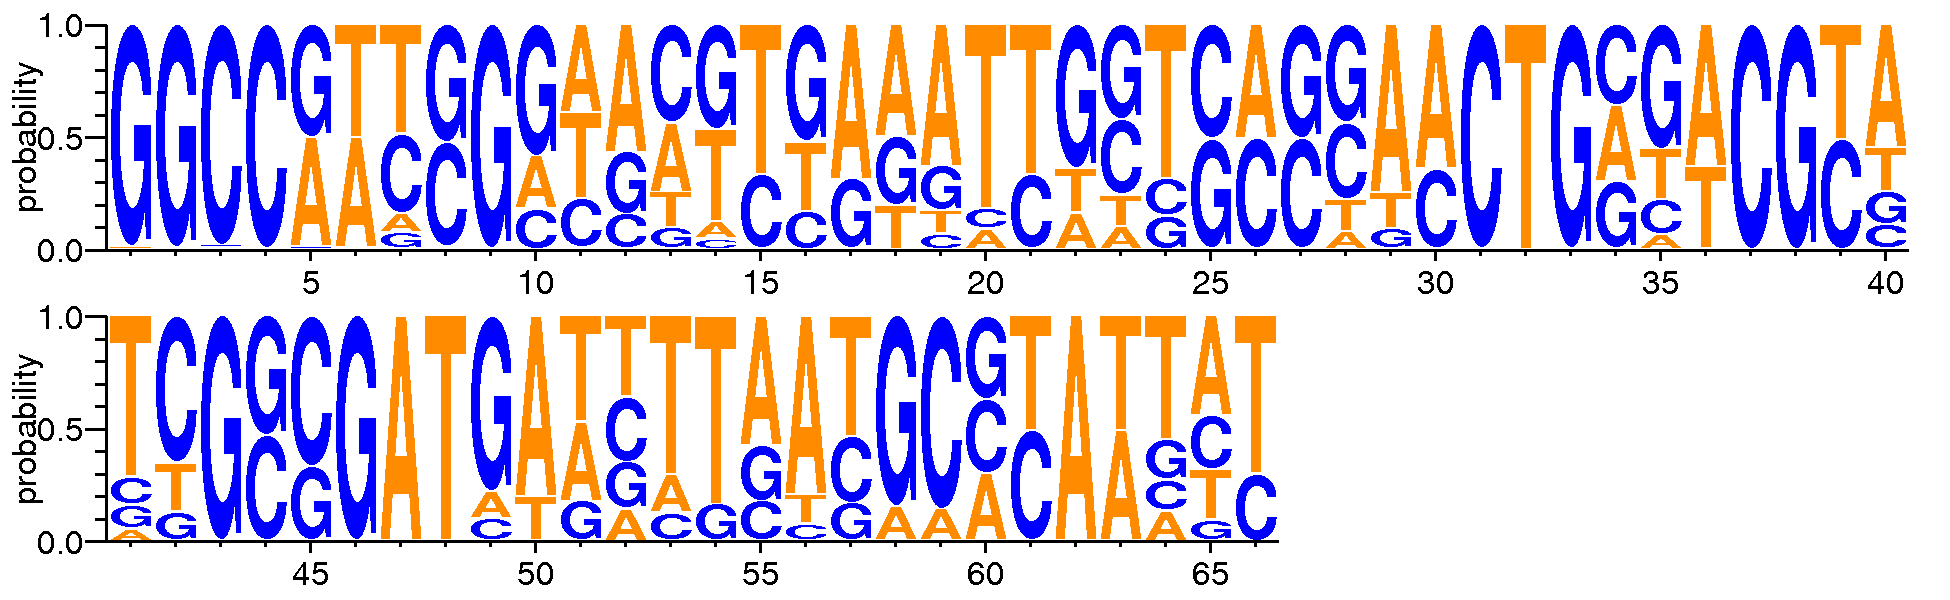

In [24]:
Image(makeLogoFromList(allDF[0].seq))

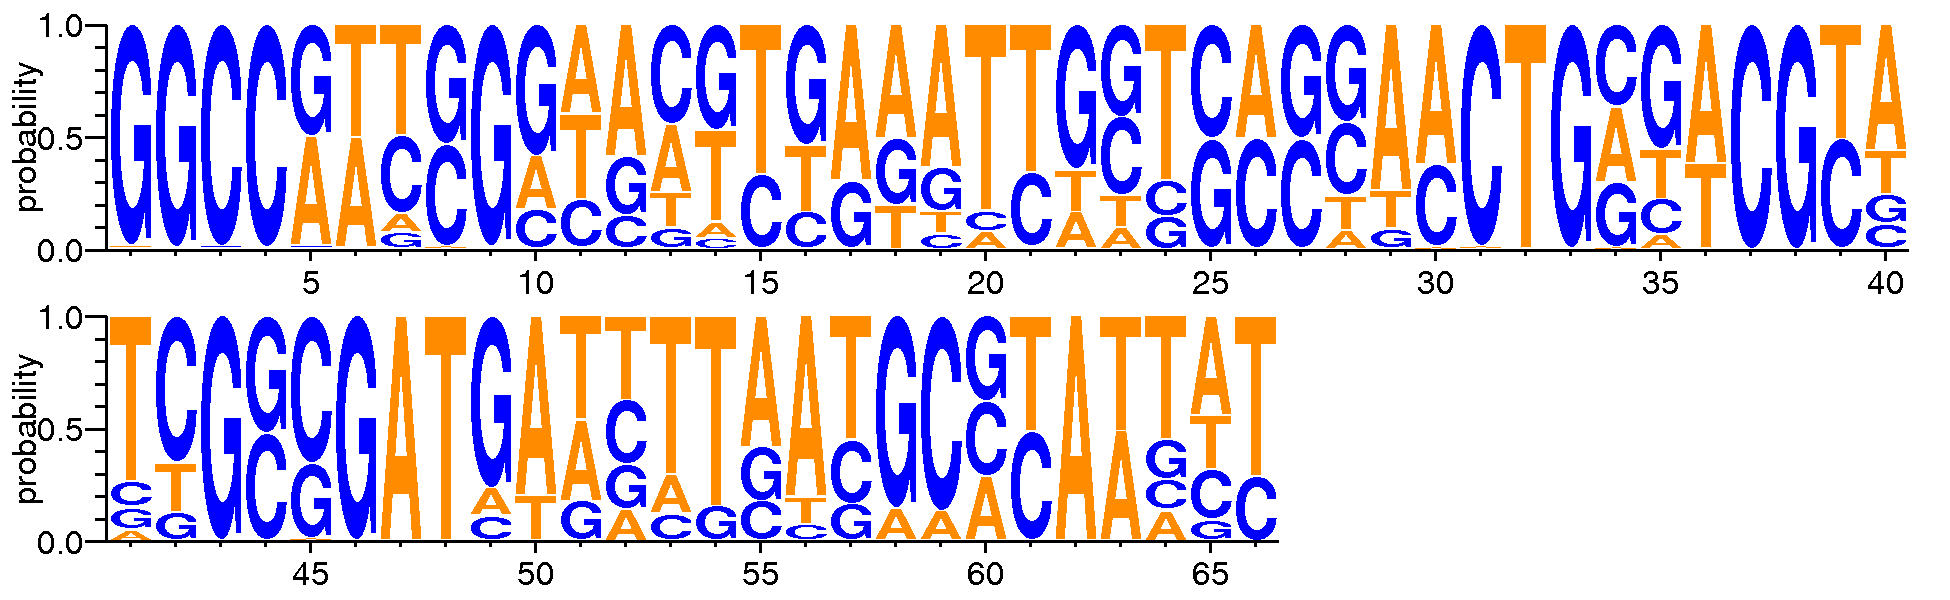

In [25]:
Image(makeLogoFromList(allDF[1].seq))

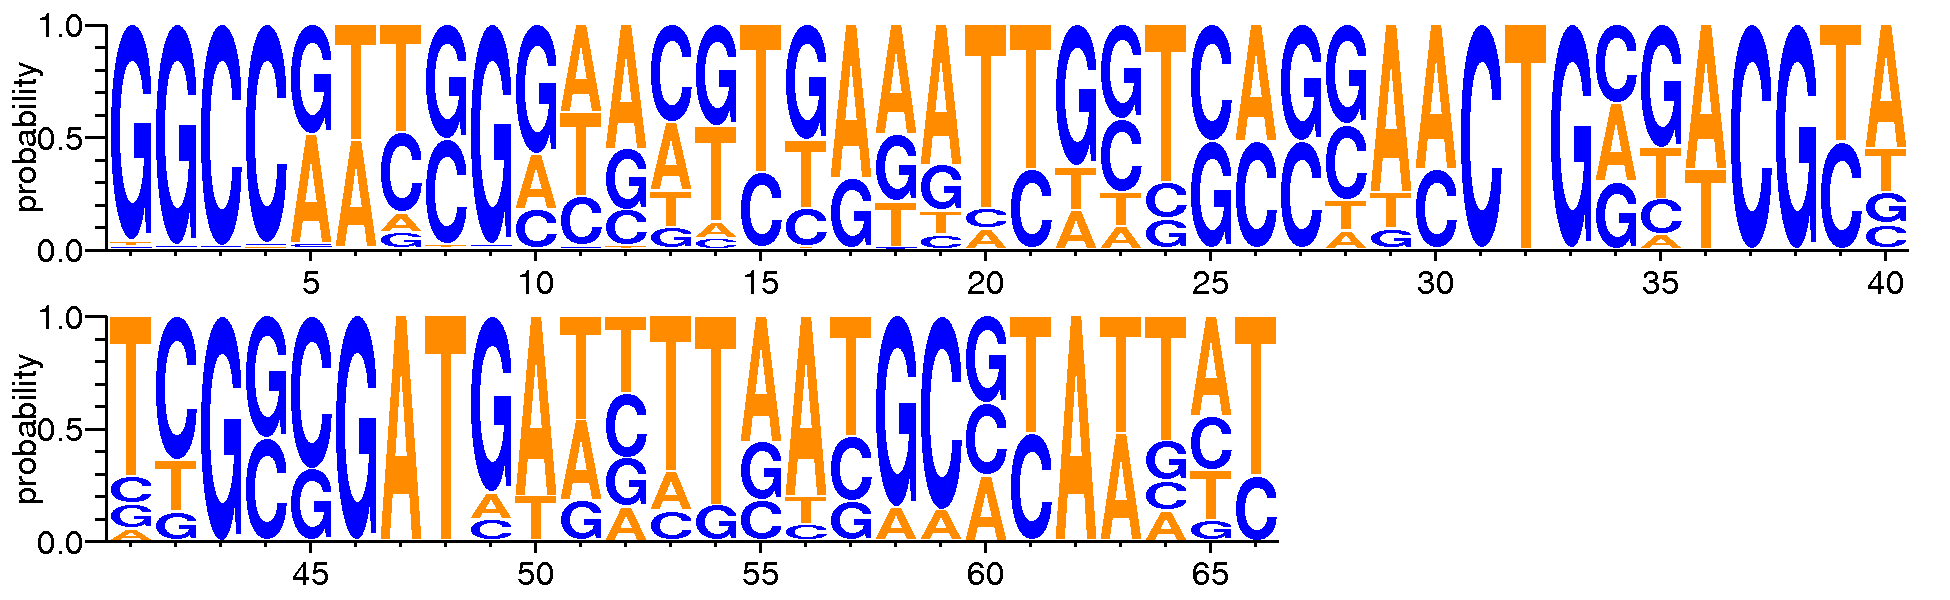

In [26]:
Image(makeLogoFromList(allDF[2].seq))

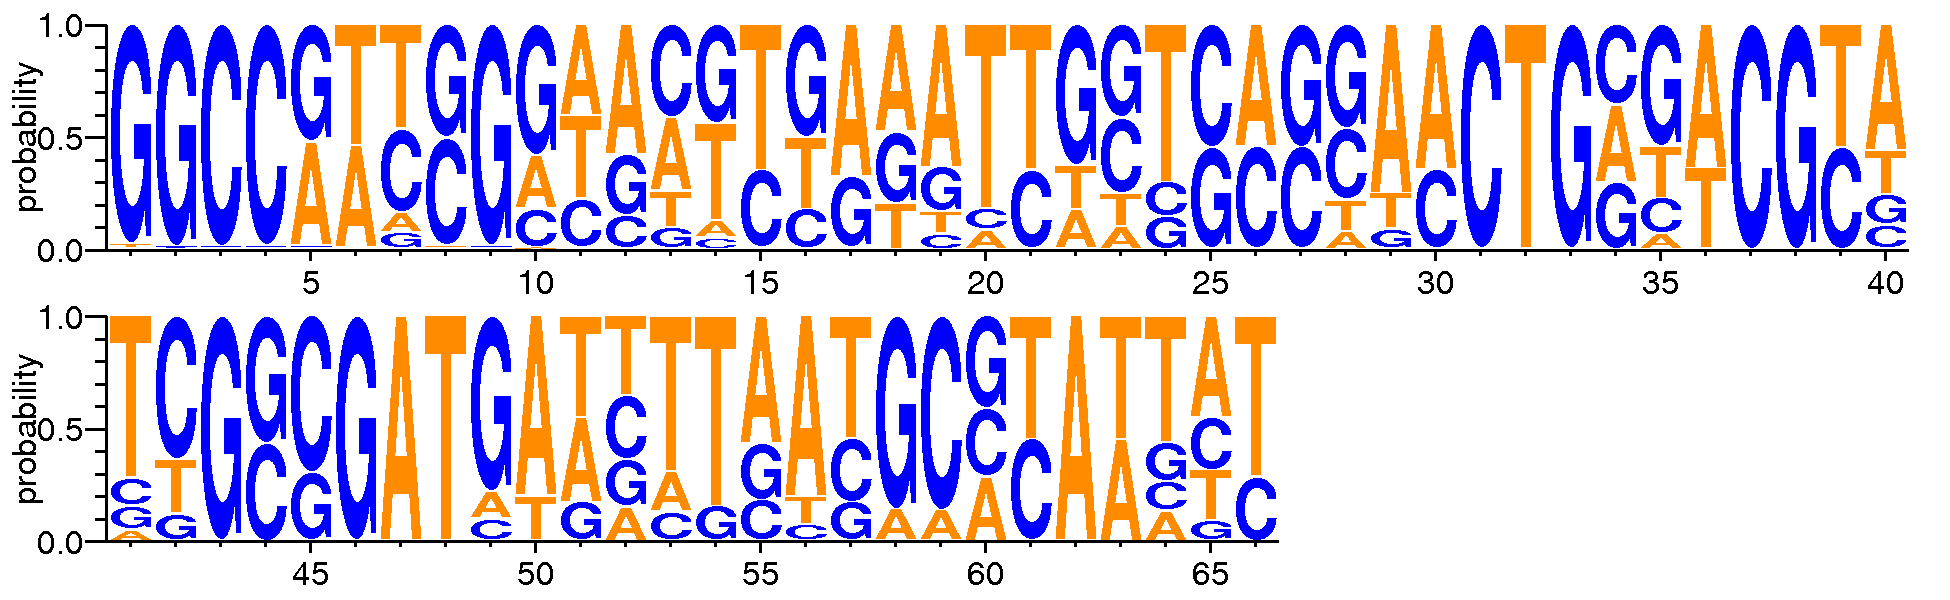

In [27]:
Image(makeLogoFromList(allDF[3].seq))

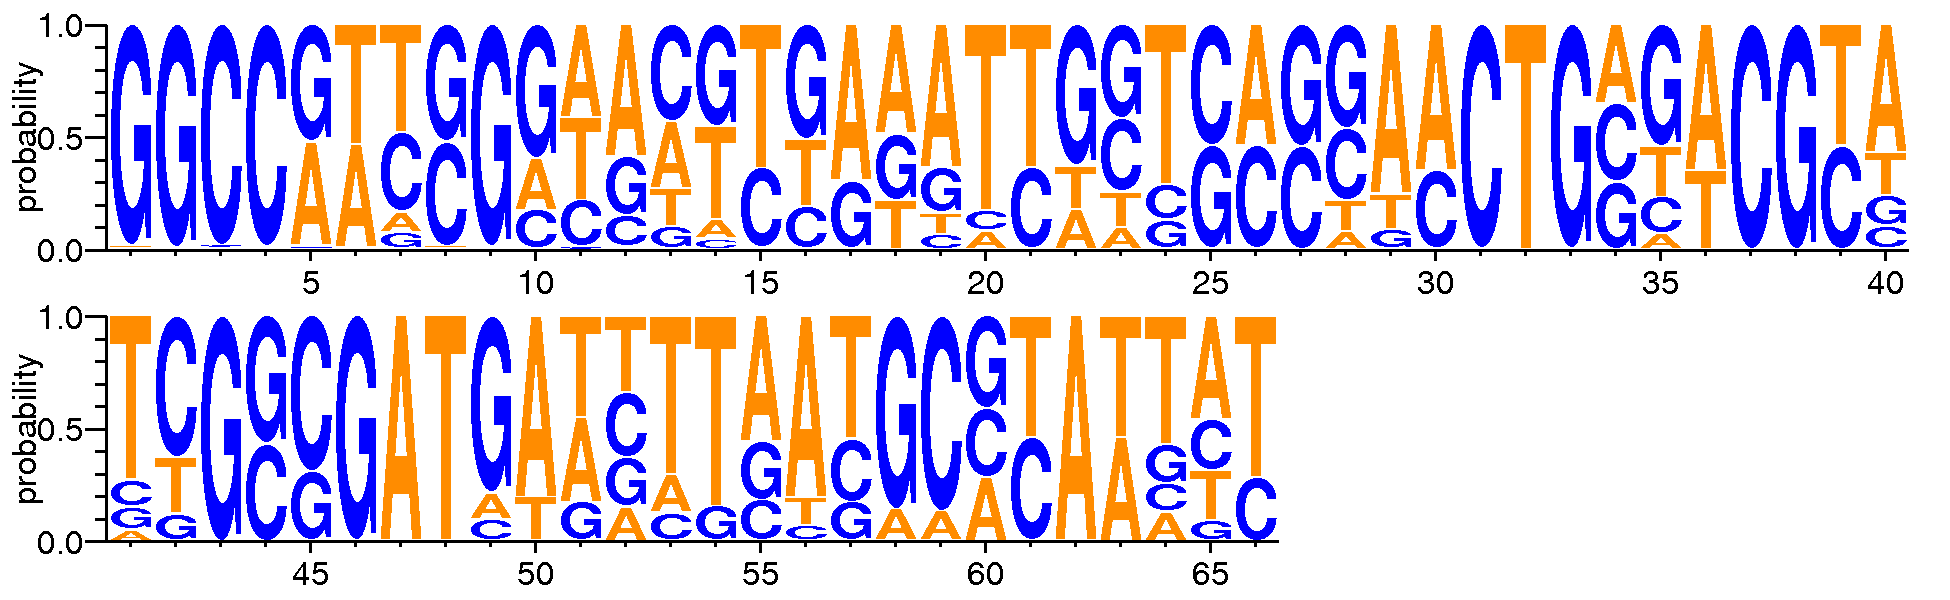

In [28]:
Image(makeLogoFromList(allDF[4].seq))